In [1]:
import os

import numpy as np
import pandas as pd

import scanpy as sc

In [2]:
sc.set_figure_params(dpi=80, dpi_save=300)

In [3]:
import time
import logging
logging.basicConfig(filename='./logging.txt', level=logging.DEBUG)

In [4]:
#dge_1 = pd.read_csv("../../orig_data/Lung_1_500more_dge.txt.gz", sep=' ').fillna(0)
#dge_2 = pd.read_csv("../../orig_data/Lung_2_500more_dge.txt.gz", sep=' ').fillna(0)
#dge_3 = pd.read_csv("../../orig_data/Lung_3_500more_dge.txt.gz", sep=' ').fillna(0)
dge_4 = pd.read_csv("../orig_data/Lung_P7_8_dge.txt.gz", sep=' ').fillna(0)
dge_5 = pd.read_csv("../orig_data/Lung_P7_9_dge.txt.gz", sep=' ').fillna(0)
#merged_dge = pd.concat([dge_1, dge_2, dge_3, dge_4, dge_5], axis=1, join='inner')
merged_dge = pd.concat([dge_4, dge_5], axis=1, join='inner')

In [5]:
print(merged_dge.shape)
print(merged_dge.index[1:5])
print(merged_dge.columns[1:5])

(23433, 2150)
Index(['Rp1', 'Sox17', 'Mrpl15', 'Lypla1'], dtype='object')
Index(['TENX_AdultLung_P7_8.AAACGGGTCTCGTATT',
       'TENX_AdultLung_P7_8.AAAGATGCAGATCTGT',
       'TENX_AdultLung_P7_8.AAATGCCAGATAGTCA',
       'TENX_AdultLung_P7_8.AAATGCCCAAACTGCT'],
      dtype='object')


In [6]:
dge = sc.AnnData(merged_dge.T)

In [7]:
#check
print(dge.shape)
print(dge.obs_names[1:5])
print(dge.var_names[1:5])

(2150, 23433)
Index(['TENX_AdultLung_P7_8.AAACGGGTCTCGTATT',
       'TENX_AdultLung_P7_8.AAAGATGCAGATCTGT',
       'TENX_AdultLung_P7_8.AAATGCCAGATAGTCA',
       'TENX_AdultLung_P7_8.AAATGCCCAAACTGCT'],
      dtype='object')
Index(['Rp1', 'Sox17', 'Mrpl15', 'Lypla1'], dtype='object')


In [8]:
np.where(np.isnan(dge.X))

(array([], dtype=int64), array([], dtype=int64))

In [9]:
anno_df = pd.DataFrame(dge.obs_names, columns=['CellID'])
anno_df['10X_CellID'] = anno_df['CellID'].apply(lambda x: '10X_'+'_'.join(x.replace('.', '_').split('_')[2:]))
anno_df['Batch'] = anno_df['CellID'].apply(lambda x: x.split('.')[0])

In [10]:
TENX_anno_df = pd.read_csv("../orig_data/annotations_droplet.csv", header=0, index_col=0, sep=',')

/home/ggj/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (10,12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
merged_anno_df = anno_df.join(TENX_anno_df, on='10X_CellID', how='left')[['CellID', 'Batch', 'cell_ontology_class', 'channel']]

In [12]:
celltype_dict = {
    'B cell':'B cell',
    'T cell':'T cell',
    'alveolar macrophage':'Macrophage',
    'ciliated columnar cell of tracheobronchial tree':'Ciliated columnar cell',
    'classical monocyte':'Monocyte',
    'leukocyte':'Leukocyte',
    'lung endothelial cell':'Endothelial cell',
    'mast cell':'Mast cell',
    'myeloid cell':'Myeloid cell',
    'natural killer cell':'NK cell',
    'non-classical monocyte':'Monocyte',
    'stromal cell':'Stromal cell',
    'type II pneumocyte':'AT2 cell',
    'nan':'other'
}
def proc_cellAnno(x):
    x = str(x)
    if x in celltype_dict.keys():
        return celltype_dict[x]
merged_anno_df['CellType'] = merged_anno_df['cell_ontology_class'].apply(proc_cellAnno)

In [13]:
#check
merged_anno_df.iloc[1:5, :]

,CellID,Batch,cell_ontology_class,channel,CellType
1,TENX_AdultLung_P7_8.AAACGGGTCTCGTATT,TENX_AdultLung_P7_8,alveolar macrophage,10X_P7_8,Macrophage
2,TENX_AdultLung_P7_8.AAAGATGCAGATCTGT,TENX_AdultLung_P7_8,B cell,10X_P7_8,B cell
3,TENX_AdultLung_P7_8.AAATGCCAGATAGTCA,TENX_AdultLung_P7_8,natural killer cell,10X_P7_8,NK cell
4,TENX_AdultLung_P7_8.AAATGCCCAAACTGCT,TENX_AdultLung_P7_8,T cell,10X_P7_8,T cell


In [14]:
for i in merged_anno_df.columns.values:
    dge.obs[i] = merged_anno_df[i].values

In [16]:
#check
print(dge.obs['CellID'][1:5])
print(dge.obs['Batch'].unique())
print(dge.obs['Batch'].describe())
print(dge.obs['CellType'].unique())
print(dge.obs['CellType'].describe())
print(dge)

TENX_AdultLung_P7_8.AAACGGGTCTCGTATT    TENX_AdultLung_P7_8.AAACGGGTCTCGTATT
TENX_AdultLung_P7_8.AAAGATGCAGATCTGT    TENX_AdultLung_P7_8.AAAGATGCAGATCTGT
TENX_AdultLung_P7_8.AAATGCCAGATAGTCA    TENX_AdultLung_P7_8.AAATGCCAGATAGTCA
TENX_AdultLung_P7_8.AAATGCCCAAACTGCT    TENX_AdultLung_P7_8.AAATGCCCAAACTGCT
Name: CellID, dtype: object
['TENX_AdultLung_P7_8' 'TENX_AdultLung_P7_9']
count                    2150
unique                      2
top       TENX_AdultLung_P7_9
freq                     1525
Name: Batch, dtype: object
['Myeloid cell' 'Macrophage' 'B cell' 'NK cell' 'T cell'
 'Endothelial cell' 'Stromal cell' 'Monocyte' 'Leukocyte'
 'Ciliated columnar cell' 'AT2 cell' 'other' 'Mast cell']
count                 2150
unique                  13
top       Endothelial cell
freq                   458
Name: CellType, dtype: object
AnnData object with n_obs × n_vars = 2150 × 23433 
    obs: 'CellID', 'Batch', 'cell_ontology_class', 'channel', 'CellType'


In [57]:
adata = dge.copy()

In [58]:
adata

AnnData object with n_obs × n_vars = 2150 × 23433 
    obs: 'CellID', 'Batch', 'cell_ontology_class', 'channel', 'CellType'

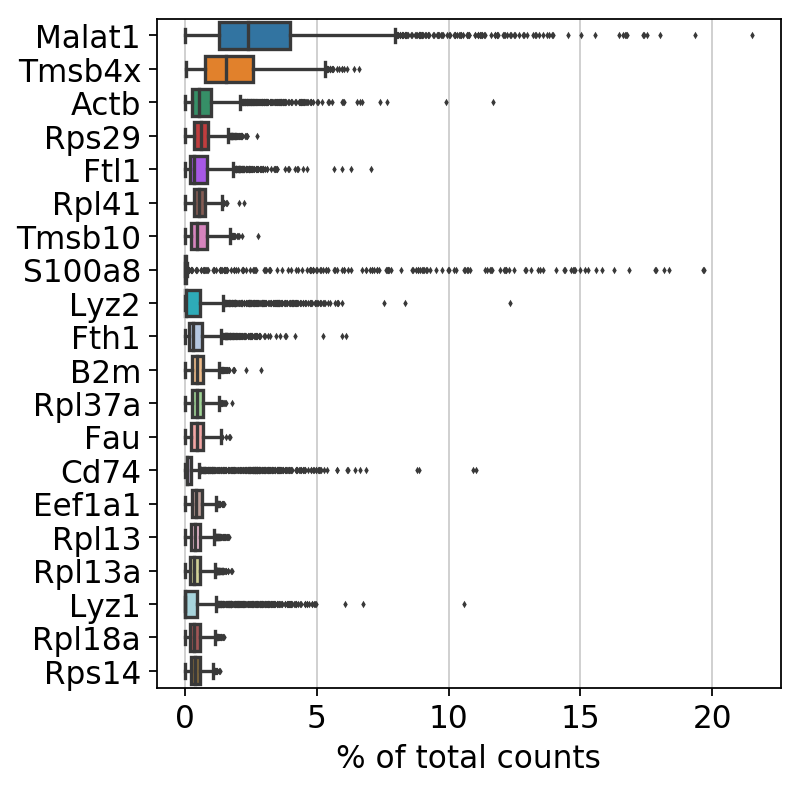

In [59]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [60]:
# filter
sc.pp.filter_cells(adata, min_genes=20)
sc.pp.filter_genes(adata, min_cells=3)

In [61]:
adata

AnnData object with n_obs × n_vars = 2150 × 14857 
    obs: 'CellID', 'Batch', 'cell_ontology_class', 'channel', 'CellType', 'n_genes'
    var: 'n_cells'

In [62]:
mito_genes = [name for name in adata.var_names if name.startswith('mt-')]
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
adata.obs['n_counts'] = adata.X.sum(axis=1)

... storing 'Batch' as categorical
... storing 'cell_ontology_class' as categorical
... storing 'channel' as categorical
... storing 'CellType' as categorical


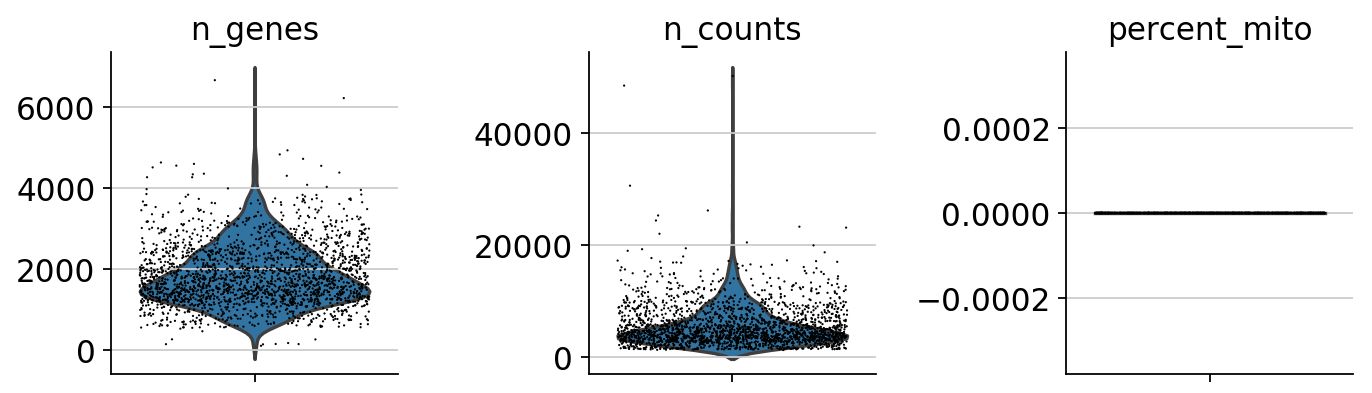

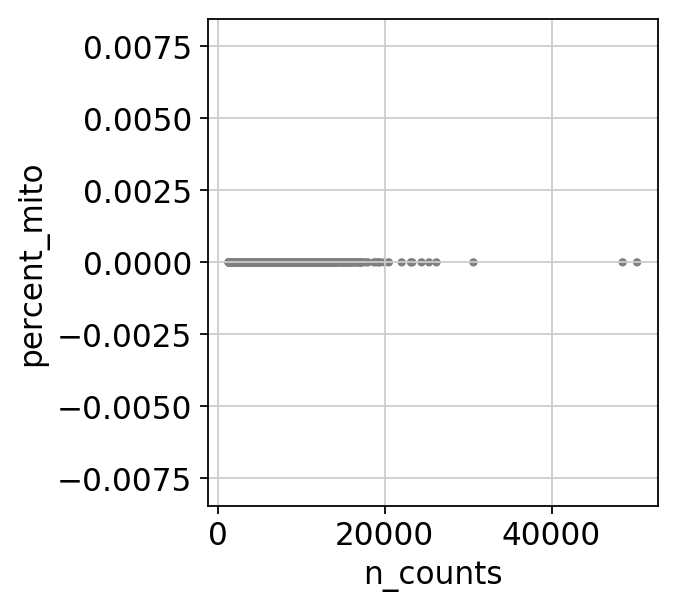

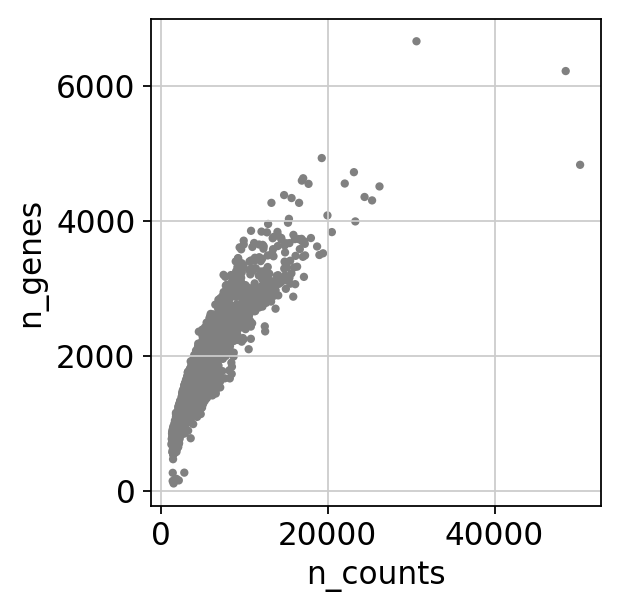

In [63]:
## filter the cells
sc.pl.violin(adata, ['n_genes', 'n_counts','percent_mito'],jitter=0.4, multi_panel=True)
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [64]:
# we actually filter nothing
adata = adata[adata.obs['n_genes'] < 6000, :]
adata = adata[adata.obs['percent_mito'] < 0.3, :]

In [65]:
adata

View of AnnData object with n_obs × n_vars = 2148 × 14857 
    obs: 'CellID', 'Batch', 'cell_ontology_class', 'channel', 'CellType', 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells'

In [66]:
## normalize
sc.pp.normalize_per_cell(adata)
adata.raw = sc.pp.log1p(adata, copy=True)

In [67]:
filter_result = sc.pp.filter_genes_dispersion(adata.X, min_mean=0.01, max_mean=15, min_disp=0.5)#2128genes

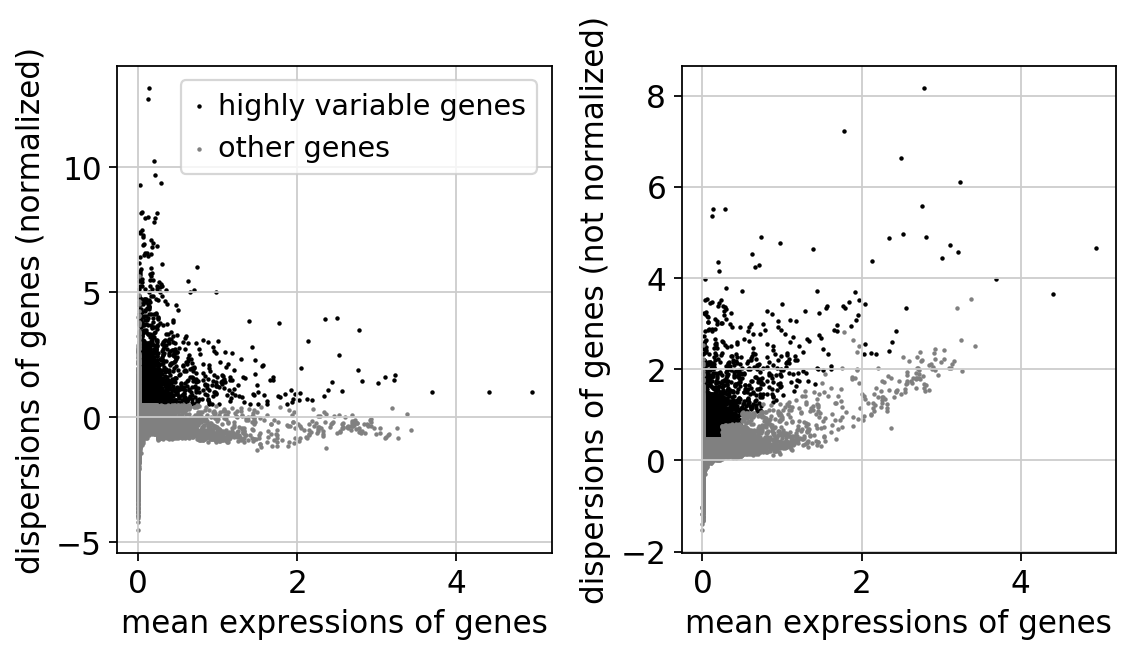

(2148, 2128)

In [68]:
sc.pl.filter_genes_dispersion(filter_result)
adata[:, filter_result.gene_subset].shape

In [69]:
hvgs = adata.var_names[filter_result.gene_subset]

In [70]:
## Actually do the filtering.
#adata1=adata
adata = adata[:, filter_result.gene_subset]

In [31]:
adata_base = adata.copy()

In [3]:
adata_base = sc.read_h5ad("adata_base.h5ad")
adata_base.obs['tissue'] = adata_base.obs['Batch'].apply(lambda x: x.split('-')[0])

In [32]:
## scale the data
sc.pp.scale(adata_base, max_value=10)

In [33]:
## PCA
sc.tl.pca(adata_base)
# Pick nPC
#sc.pl.pca_variance_ratio(adata, log=True, show=100, n_pcs=100)

In [34]:
#nPC=45
sc.pp.neighbors(adata_base, n_neighbors=10,n_pcs=45)

In [35]:
#run tSNE
sc.tl.tsne(adata_base,n_pcs=45,use_fast_tsne=True,n_jobs=20,perplexity=100)

saving figure to file ./figures/tsne_Batch_Baseline.svg


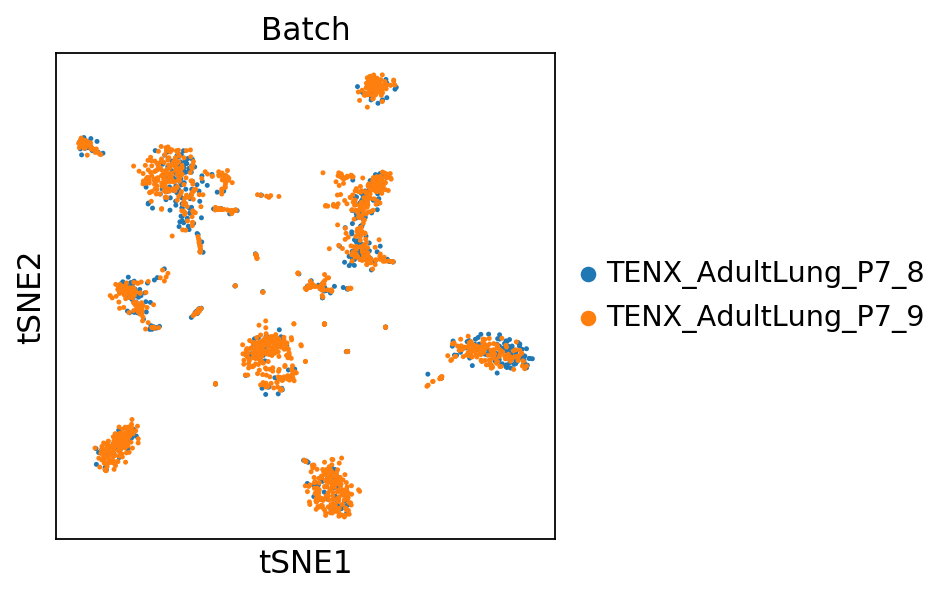

In [4]:
sc.pl.tsne(adata_base, color=['Batch'], size=20, save="_Batch_Baseline.svg")

saving figure to file ./figures/tsne_CellType_Baseline.svg


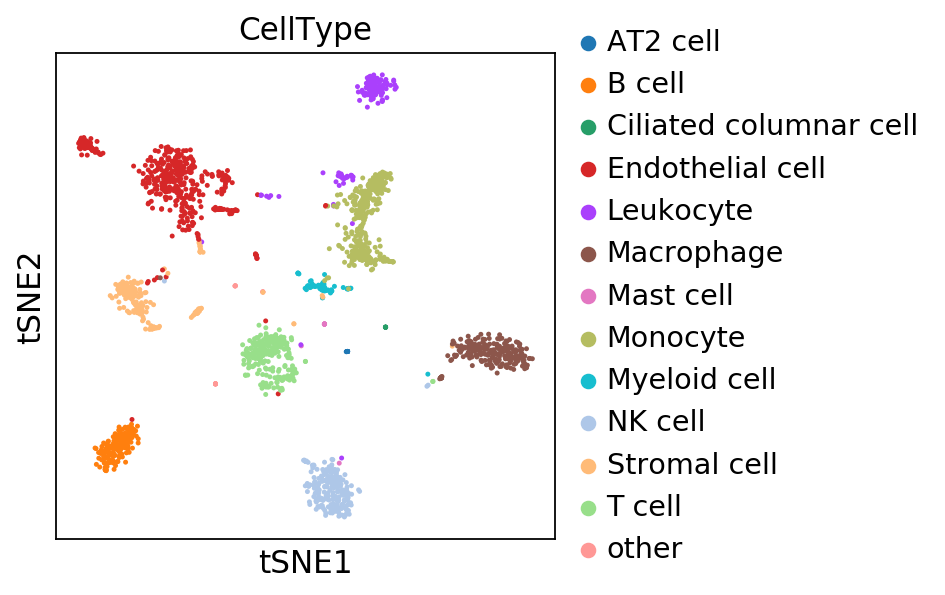

In [5]:
sc.pl.tsne(adata_base, color=['CellType'], size=20, save="_CellType_Baseline.svg")

saving figure to file ./figures/tsne_CellType_Baseline_ondata.svg


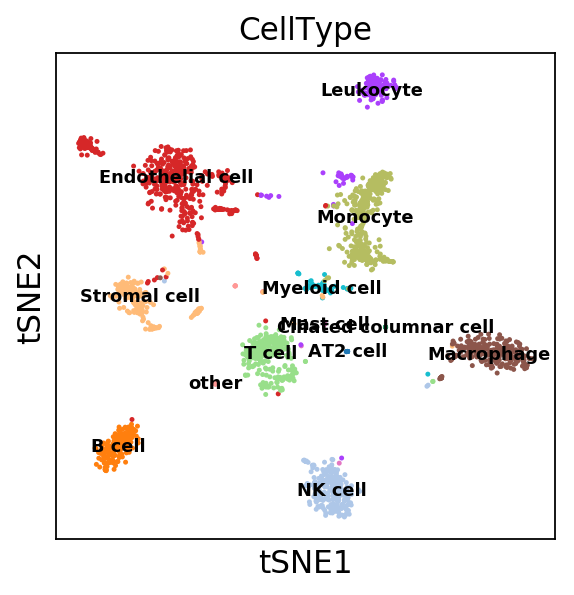

In [6]:
sc.pl.tsne(adata_base, color=['CellType'], size=20, legend_loc='on data', legend_fontsize=8, save="_CellType_Baseline_ondata.svg")

saving figure to file ./figures/tsne_Cluster_baseline.svg


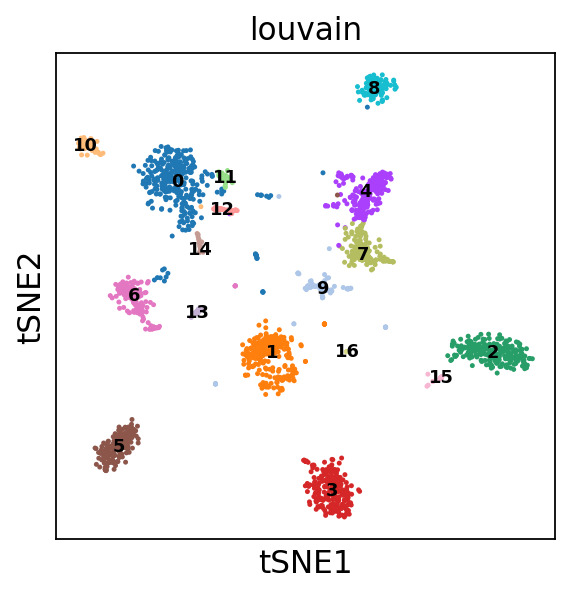

In [7]:
#res=0.6
sc.tl.louvain(adata_base, resolution=0.6)
sc.pl.tsne(adata_base, color='louvain',size=20,legend_loc='on data', legend_fontsize=8,save='_Cluster_baseline.svg')

In [40]:
adata_base.obs['louvain'].to_csv("./cluster_Baseline.txt", index=False)

In [115]:
adata_reg = adata.copy()

In [8]:
adata_reg = sc.read_h5ad("adata_reg.h5ad")
adata_reg.obs['tissue'] = adata_reg.obs['Batch'].apply(lambda x: x.split('-')[0])

In [116]:
## Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.
logging.info("start scanpy regout\n\n")
start = time.clock()
sc.pp.regress_out(adata_reg, ['n_counts'])
end = time.clock()
logging.debug("time scale: second")
logging.debug("scanpy regout total running time:\t%f", end - start)
logging.info("\n\nscanpy regout")

/home/ggj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ggj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """


In [117]:
## scale the data
sc.pp.scale(adata_reg, max_value=10)

In [118]:
## PCA
sc.tl.pca(adata_reg)
# Pick nPC
#sc.pl.pca_variance_ratio(adata, log=True, show=100, n_pcs=100)

In [119]:
#nPC=45
sc.pp.neighbors(adata_reg, n_neighbors=10,n_pcs=45)

In [120]:
#run tSNE
sc.tl.tsne(adata_reg,n_pcs=45,use_fast_tsne=True,n_jobs=20,perplexity=100)

saving figure to file ./figures/tsne_Batch_reg.svg


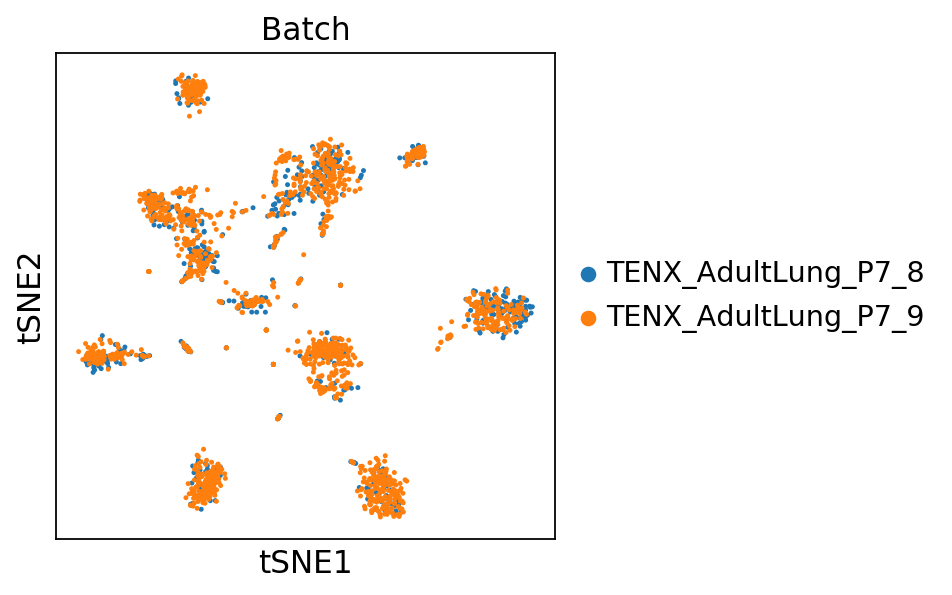

In [9]:
sc.pl.tsne(adata_reg, color=['Batch'], size=20, save="_Batch_reg.svg")

saving figure to file ./figures/tsne_CellType_reg.svg


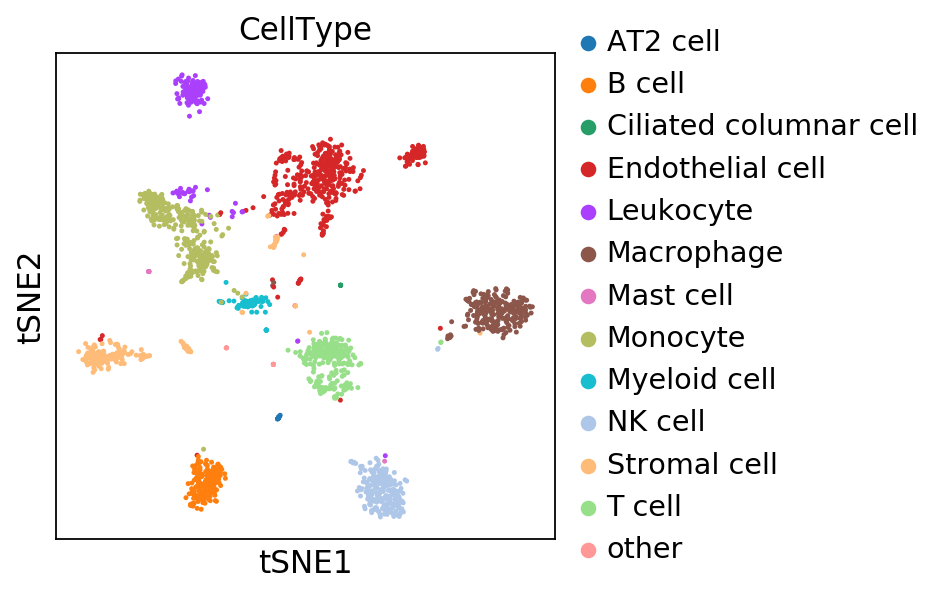

In [10]:
sc.pl.tsne(adata_reg, color=['CellType'], size=20, save="_CellType_reg.svg")

saving figure to file ./figures/tsne_CellType_reg_ondata.svg


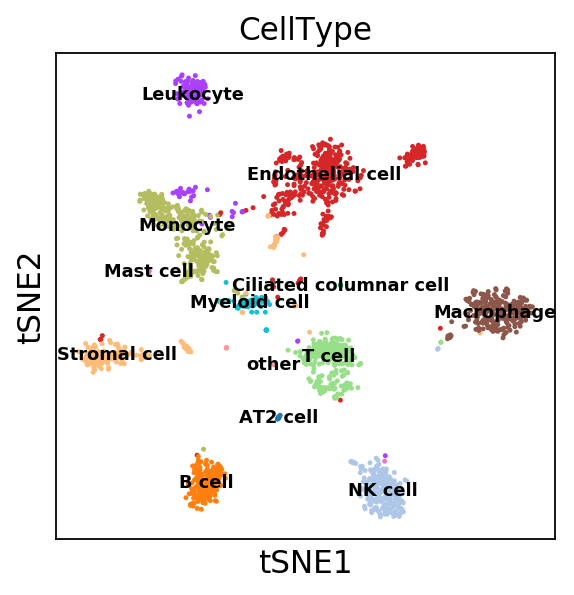

In [11]:
sc.pl.tsne(adata_reg, color=['CellType'], size=20, legend_loc='on data', legend_fontsize=8, save="_CellType_reg_ondata.svg")

saving figure to file ./figures/tsne_Cluster_reg.svg


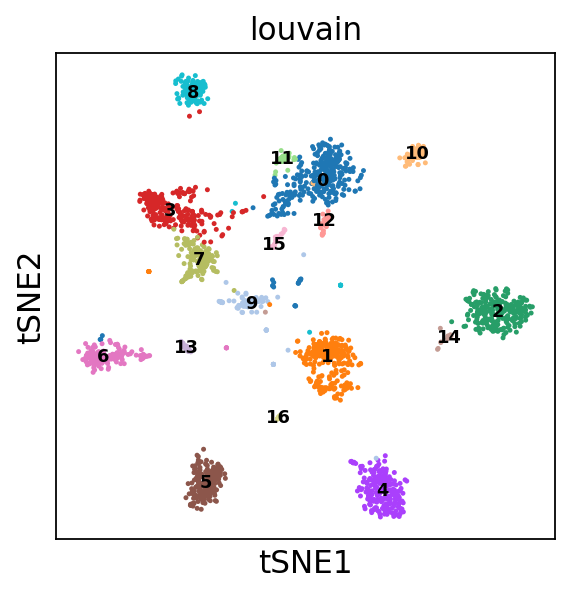

In [12]:
#res=0.6
sc.tl.louvain(adata_reg, resolution=0.6)
sc.pl.tsne(adata_reg, color='louvain',size=20,legend_loc='on data', legend_fontsize=8, save='_Cluster_reg.svg')

In [130]:
adata_reg.obs['louvain'].to_csv("./cluster_reg.txt", index=False)

In [71]:
adata_combat = adata.copy()

In [13]:
adata_combat = sc.read_h5ad("adata_combat.h5ad")
adata_combat.obs['tissue'] = adata_combat.obs['Batch'].apply(lambda x: x.split('-')[0])

In [72]:
logging.info("start scanpy combat\n\n")
start = time.clock()
sc.pp.combat(adata_combat, key='Batch')
end = time.clock()
logging.debug("time scale: second")
logging.debug("scanpy combat running time:\t%f", end - start)
logging.info("\n\nEnd scanpy combat")

/home/ggj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
Standardizing Data across genes.
found 2 batches
found 0 categorical variables:	
Fitting L/S model and finding priors
Finding parametric adjustments


Adjusting data


/home/ggj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.


In [73]:
## scale the data
sc.pp.scale(adata_combat, max_value=10)

In [74]:
## PCA
sc.tl.pca(adata_combat)
# Pick nPC
#sc.pl.pca_variance_ratio(adata, log=True, show=100, n_pcs=100)

In [75]:
#nPC=45
sc.pp.neighbors(adata_combat, n_neighbors=10,n_pcs=45)

In [76]:
#run tSNE
sc.tl.tsne(adata_combat,n_pcs=45,use_fast_tsne=True,n_jobs=20,perplexity=100)

saving figure to file ./figures/tsne_Batch_Combat.svg


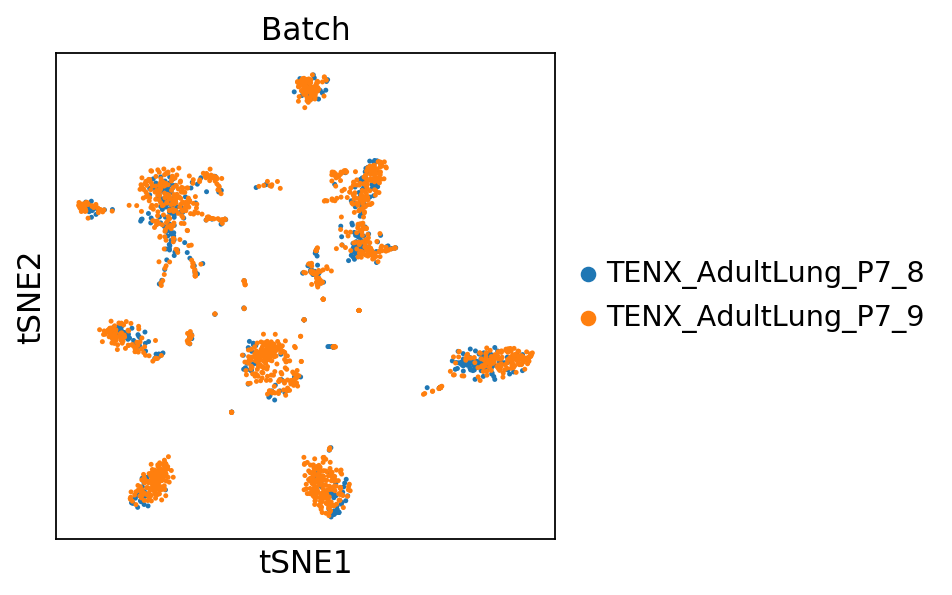

In [14]:
sc.pl.tsne(adata_combat, color=['Batch'], size=20, save="_Batch_Combat.svg")

saving figure to file ./figures/tsne_CellType_Combat.svg


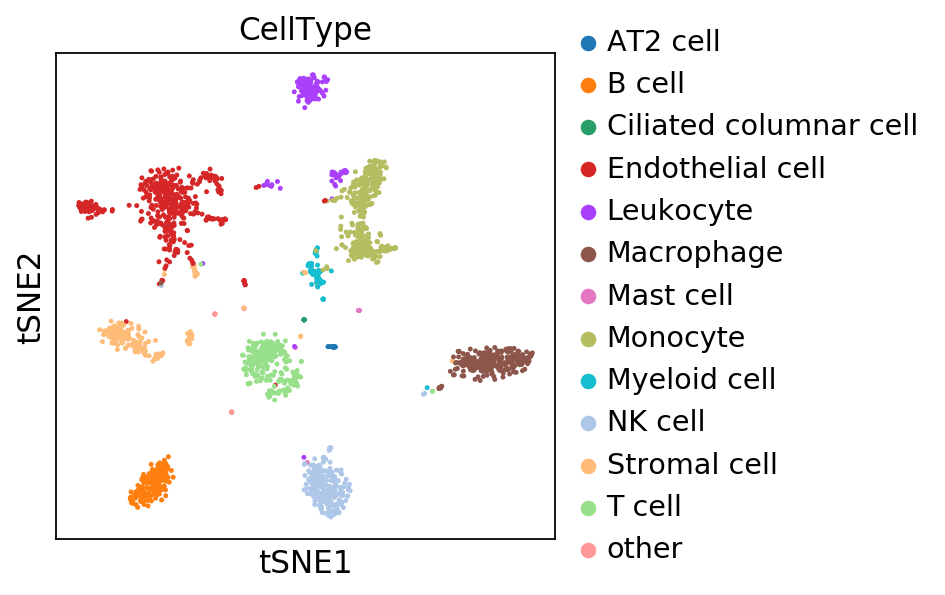

In [15]:
sc.pl.tsne(adata_combat, color=['CellType'], size=20, save="_CellType_Combat.svg")

saving figure to file ./figures/tsne_CellType_Combat_ondata.svg


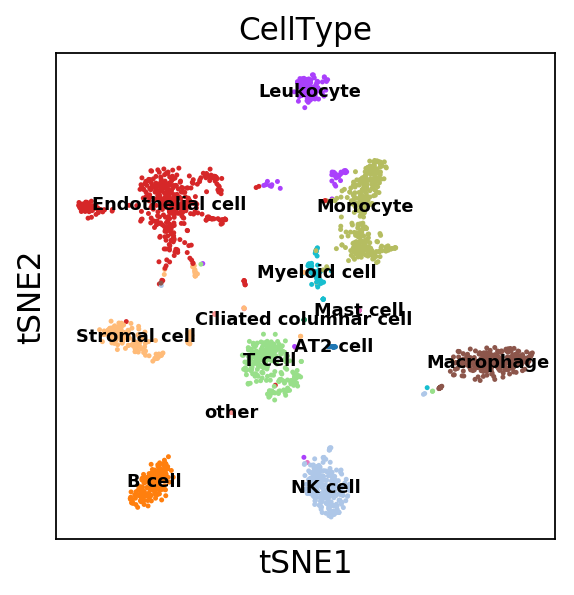

In [16]:
sc.pl.tsne(adata_combat, color=['CellType'], size=20, legend_loc='on data', legend_fontsize=8, save="_CellType_Combat_ondata.svg")

saving figure to file ./figures/tsne_Cluster_Combat.svg


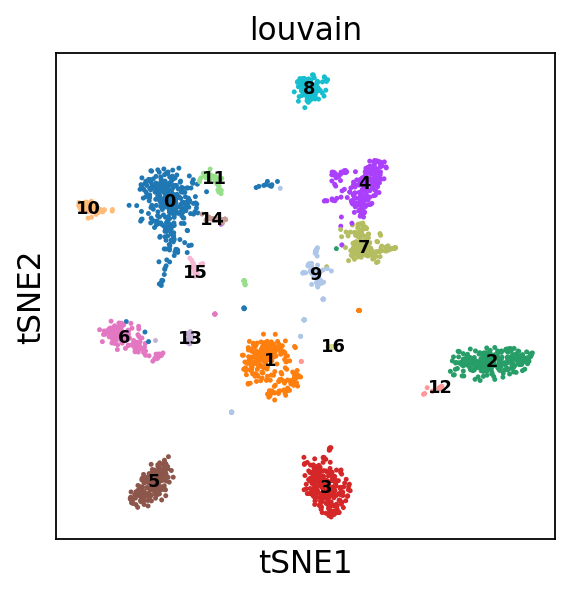

In [17]:
#res=0.6
sc.tl.louvain(adata_combat, resolution=0.6)
sc.pl.tsne(adata_combat, color='louvain', size=20, legend_loc='on data', legend_fontsize=8,save='_Cluster_Combat.svg')

In [82]:
adata_combat.obs['louvain'].to_csv("./cluster_Combat.txt", index=False)

In [83]:
adata_scanorama = adata.copy()

In [18]:
corrected_merged_dge = sc.read_h5ad("adata_scanorama.h5ad")
corrected_merged_dge.obs['tissue'] = corrected_merged_dge.obs['Batch'].apply(lambda x: x.split('-')[0])

In [84]:
adata_list = [adata_scanorama[adata_scanorama.obs['Batch'] == i] for i in adata_scanorama.obs['Batch'].unique()]

In [85]:
#check
print(adata_list[0].shape)
print(adata_list[0])

(624, 2128)
View of AnnData object with n_obs × n_vars = 624 × 2128 
    obs: 'CellID', 'Batch', 'cell_ontology_class', 'channel', 'CellType', 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells'


In [86]:
import scanorama

In [87]:
logging.info("start scanorama\n\n")
start = time.clock()
intergrated, corrected = scanorama.correct_scanpy(adata_list, return_dimred=True)
correct_end = time.clock()
corrected_merged_dge = corrected[0].concatenate(corrected[1:], join='outer')
merged_end = time.clock()
logging.debug("time scale: second")
logging.debug("scanoram correct batch time:\t%f", correct_end - start)
logging.debug("scanoram merging time:\t%f", merged_end - correct_end)
logging.debug("scanoram total running time:\t%f", merged_end - start)
logging.info("\n\nend scanorama")

/home/ggj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


Found 2128 genes among all datasets
[[0.         0.98076923]
 [0.         0.        ]]
Processing datasets (0, 1)


/home/ggj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.
/home/ggj/anaconda3/lib/python3.7/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/home/ggj/anaconda3/lib/python3.7/site-packages/scipy/sparse/lil.py:514: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):
/home/ggj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Pytho

In [88]:
corrected_merged_dge.obs = adata_scanorama.obs

In [89]:
## scale the data
sc.pp.scale(corrected_merged_dge, max_value=10)

In [90]:
## PCA
sc.tl.pca(corrected_merged_dge)
# Pick nPC
#sc.pl.pca_variance_ratio(adata, log=True, show=100, n_pcs=100)

In [91]:
#nPC=45
sc.pp.neighbors(corrected_merged_dge, n_neighbors=10,n_pcs=45)

In [92]:
#run tSNE
sc.tl.tsne(corrected_merged_dge,n_pcs=45,use_fast_tsne=True,n_jobs=20,perplexity=100)

saving figure to file ./figures/tsne_Batch_Scanorama.svg


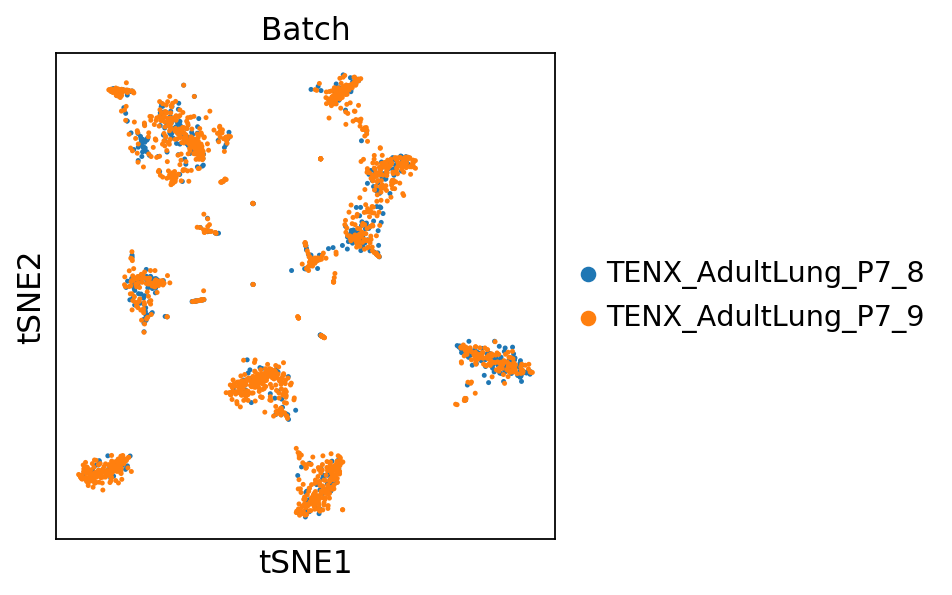

In [19]:
sc.pl.tsne(corrected_merged_dge, color=['Batch'], size=20, save="_Batch_Scanorama.svg")

saving figure to file ./figures/tsne_CellType_Scanorama.svg


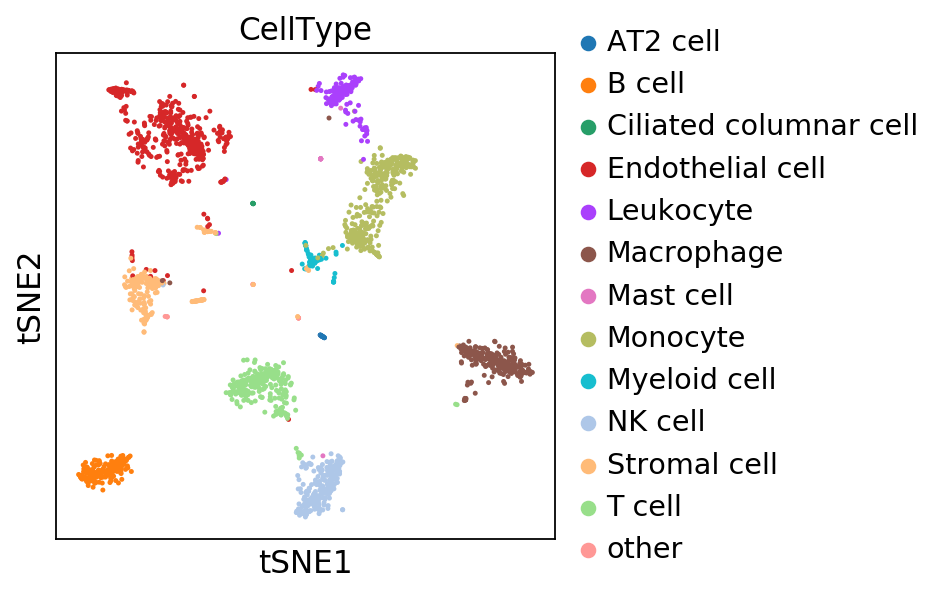

In [20]:
sc.pl.tsne(corrected_merged_dge, color=['CellType'], size=20, save="_CellType_Scanorama.svg")

saving figure to file ./figures/tsne_CellType_Scanoram_ondata.svg


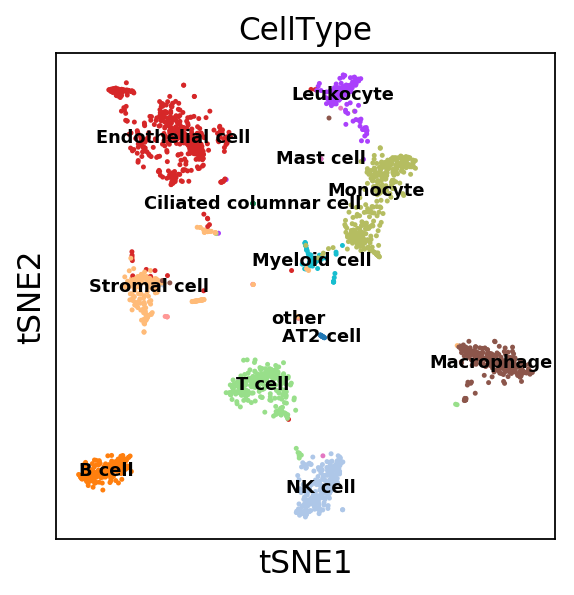

In [21]:
sc.pl.tsne(corrected_merged_dge, color=['CellType'], size=20, legend_loc='on data', legend_fontsize=8, save="_CellType_Scanoram_ondata.svg")

saving figure to file ./figures/tsne_Cluster_Scanorama.svg


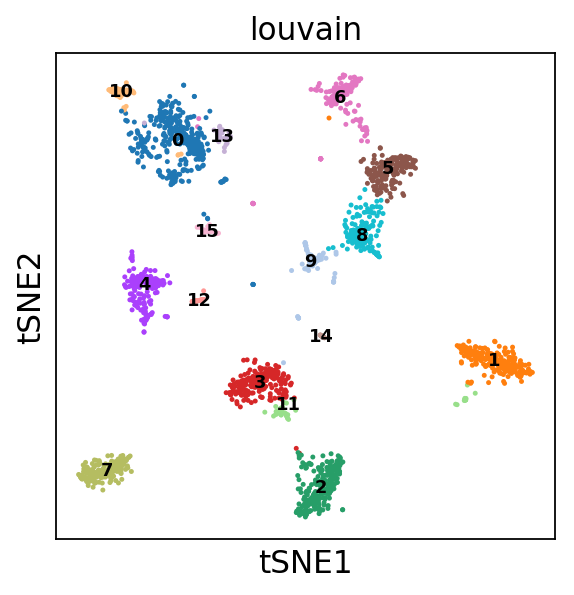

In [22]:
#res=0.6
sc.tl.louvain(corrected_merged_dge, resolution=0.6)
sc.pl.tsne(corrected_merged_dge, color='louvain', size=20, legend_loc='on data', legend_fontsize=8,save='_Cluster_Scanorama.svg')

In [97]:
corrected_merged_dge.obs['louvain'].to_csv("./cluster_Scanorama.txt", index=False)

In [98]:
import mnnpy

In [23]:
mnn_adata = sc.read_h5ad("adata_mnns.h5ad")
mnn_adata.obs['tissue'] = mnn_adata.obs['Batch'].apply(lambda x: x.split('-')[0])

In [99]:
logging.info("start MNNPY\n\n")
start = time.clock()
corrected = mnnpy.mnn_correct(adata_list[0], adata_list[1], var_subset=hvgs)
correct_end = time.clock()
mnn_adata = corrected[0]
merged_end = time.clock()
logging.debug("time scale: second")
logging.debug("MNNPY correct batch time:\t%f", correct_end - start)
logging.debug("MNNPY merging time:\t%f", merged_end - correct_end)
logging.debug("MNNPY total running time:\t%f", merged_end - start)
logging.info("\n\nend MNNPY")

/home/ggj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


Performing cosine normalization...
Starting MNN correct iteration. Reference batch: 0
Step 1 of 1: processing batch 1
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
MNN correction complete. Gathering output...
Packing AnnData object...
Done.


/home/ggj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.
/home/ggj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


In [100]:
## scale the data
sc.pp.scale(mnn_adata, max_value=10)

In [101]:
## PCA
sc.tl.pca(mnn_adata)
# Pick nPC
#sc.pl.pca_variance_ratio(adata, log=True, show=100, n_pcs=100)

In [102]:
#nPC=45
sc.pp.neighbors(mnn_adata, n_neighbors=10,n_pcs=45)

In [103]:
#run tSNE
sc.tl.tsne(mnn_adata,n_pcs=45,use_fast_tsne=True,n_jobs=20,perplexity=100)

saving figure to file ./figures/tsne_Batch_MNNs.svg


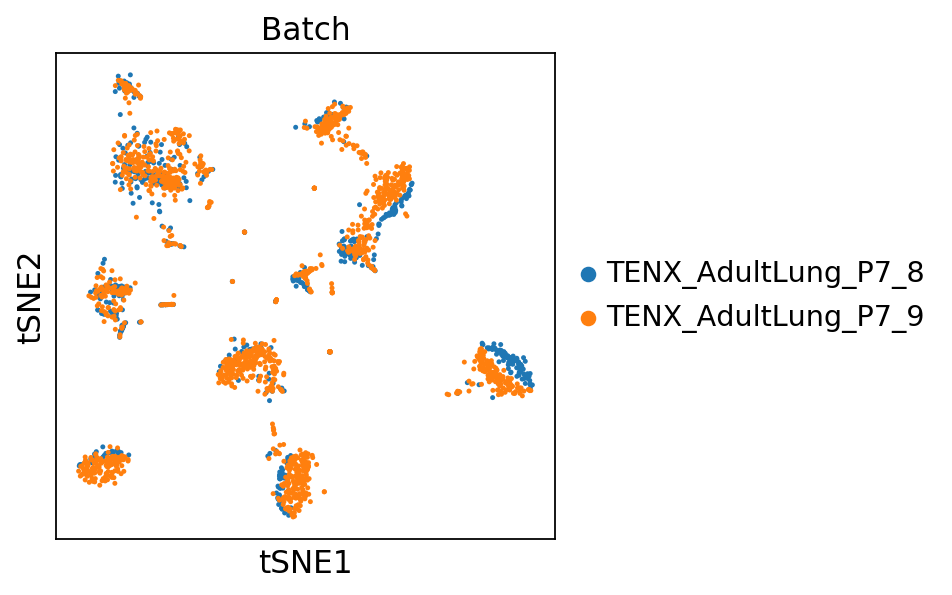

In [24]:
sc.pl.tsne(mnn_adata, color=['Batch'], size=20, save="_Batch_MNNs.svg")

saving figure to file ./figures/tsne_CellType_MNNs.svg


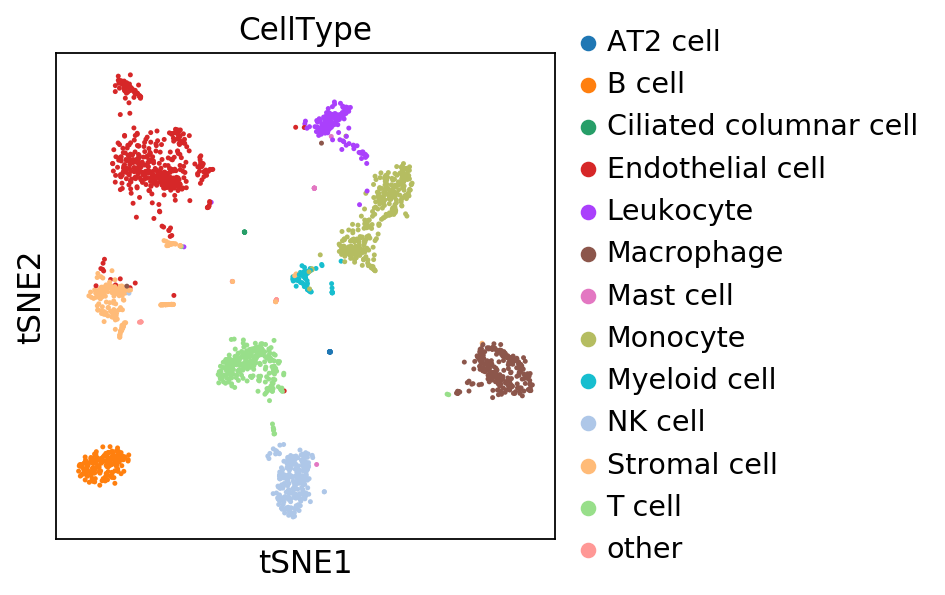

In [25]:
sc.pl.tsne(mnn_adata, color=['CellType'], size=20, save="_CellType_MNNs.svg")

saving figure to file ./figures/tsne_CellType_MNNs_ondata.svg


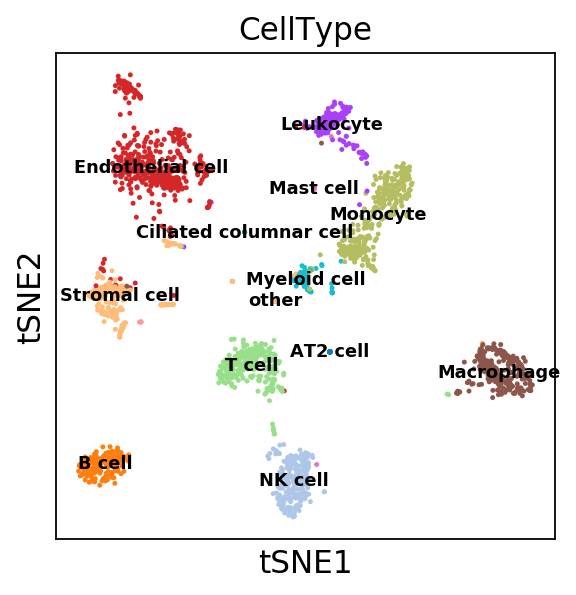

In [26]:
sc.pl.tsne(mnn_adata, color=['CellType'], size=20, legend_loc='on data', legend_fontsize=8, save="_CellType_MNNs_ondata.svg")

saving figure to file ./figures/tsne_Cluster_MNNs.svg


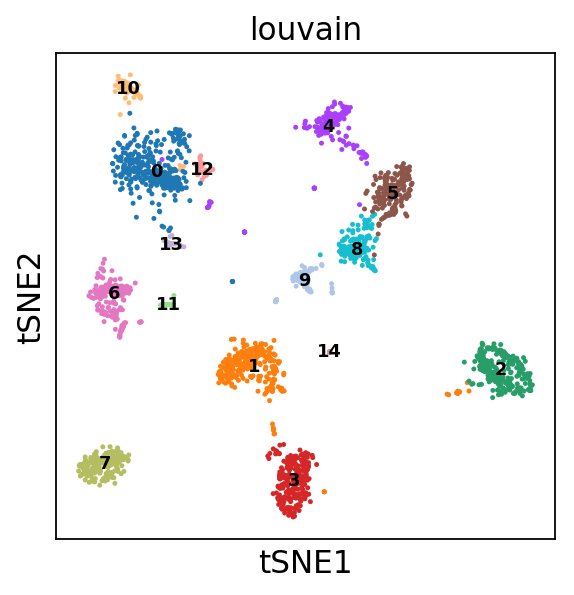

In [27]:
#res=0.6
sc.tl.louvain(mnn_adata, resolution=0.6)
sc.pl.tsne(mnn_adata, color='louvain', size=20, legend_loc='on data', legend_fontsize=8, save='_Cluster_MNNs.svg')

In [108]:
mnn_adata.obs['louvain'].to_csv("./cluster_MNNs.txt", index=False)

In [131]:
import bbknn

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind
from sklearn.metrics import silhouette_samples as sil

In [29]:
def calculate_silh(X, label_fname):
    labels = np.array( open(label_fname).read().rstrip().split() )
    idx = range(labels.shape[0])
    sil_val = sil(X[idx, :], labels[idx])
    print(np.median(sil_val))
    return sil_val

In [134]:
X = dge.X

In [30]:
X = sc.read_h5ad("dge.h5ad").X

In [31]:
# Baseline Scanpy.
print("silh score of scanpy baseline")
sil_non = calculate_silh(X, './cluster_Baseline.txt')
# regout Scanpy
print("silh score of scanpy Regout:")
sil_regout = calculate_silh(X, 'cluster_reg.txt')
# regout Scanpy
print("silh score of scanpy Combat:")
sil_scanpy = calculate_silh(X, './cluster_Combat.txt')
# scanorama scanpy
print("silh score of Scanoram:")
sil_scano = calculate_silh(X,"./cluster_Scanorama.txt")
# MNNs
print("silh score of MNNs:")
sil_MNN = calculate_silh(X,"./cluster_MNNs.txt")

silh score of scanpy baseline
-0.21538174
silh score of scanpy Regout:
-0.21555519
silh score of scanpy Combat:
-0.1982978
silh score of Scanoram:
-0.20194617
silh score of MNNs:
-0.19658375


In [32]:
print("\n\n-----Ttest------\n\n")
# t-test
print("ttest of regout to baseline:")
print(ttest_ind(sil_regout, sil_non))
print("ttest of combat to baseline:")
print(ttest_ind(sil_scanpy, sil_non))
print("ttest of scanoram to baseline:")
print(ttest_ind(sil_scano, sil_non))
print("ttest of MNNs to baseline:")
print(ttest_ind(sil_MNN, sil_non))
print("ttest of Combat to Regout:")
print(ttest_ind(sil_scanpy, sil_regout))
print("ttest of Scanoram to Regout:")
print(ttest_ind(sil_scano, sil_regout))
print("ttest of MNNs to Regout:")
print(ttest_ind(sil_MNN, sil_regout))
print("ttest of Scanoram to Combat:")
print(ttest_ind(sil_scano, sil_scanpy))
print("ttest of MNNs to Combat:")
print(ttest_ind(sil_MNN, sil_scanpy))
print("ttest of MNNs to Scanoram:")
print(ttest_ind(sil_MNN, sil_scano))



-----Ttest------


ttest of regout to baseline:
Ttest_indResult(statistic=-0.41673970462104437, pvalue=0.6768896399458562)
ttest of combat to baseline:
Ttest_indResult(statistic=3.5947853247933703, pvalue=0.0003283059549051429)
ttest of scanoram to baseline:
Ttest_indResult(statistic=3.7455460281354713, pvalue=0.00018236230207762364)
ttest of MNNs to baseline:
Ttest_indResult(statistic=5.620035913781424, pvalue=2.030106728331619e-08)
ttest of Combat to Regout:
Ttest_indResult(statistic=4.015401111934866, pvalue=6.0358223560471276e-05)
ttest of Scanoram to Regout:
Ttest_indResult(statistic=4.145764667108076, pvalue=3.452163176598329e-05)
ttest of MNNs to Regout:
Ttest_indResult(statistic=6.006578891826928, pvalue=2.051572692100173e-09)
ttest of Scanoram to Combat:
Ttest_indResult(statistic=0.3340165012528745, pvalue=0.7383834179085115)
ttest of MNNs to Combat:
Ttest_indResult(statistic=2.3459843458652614, pvalue=0.01902214897232349)
ttest of MNNs to Scanoram:
Ttest_indResult(statistic

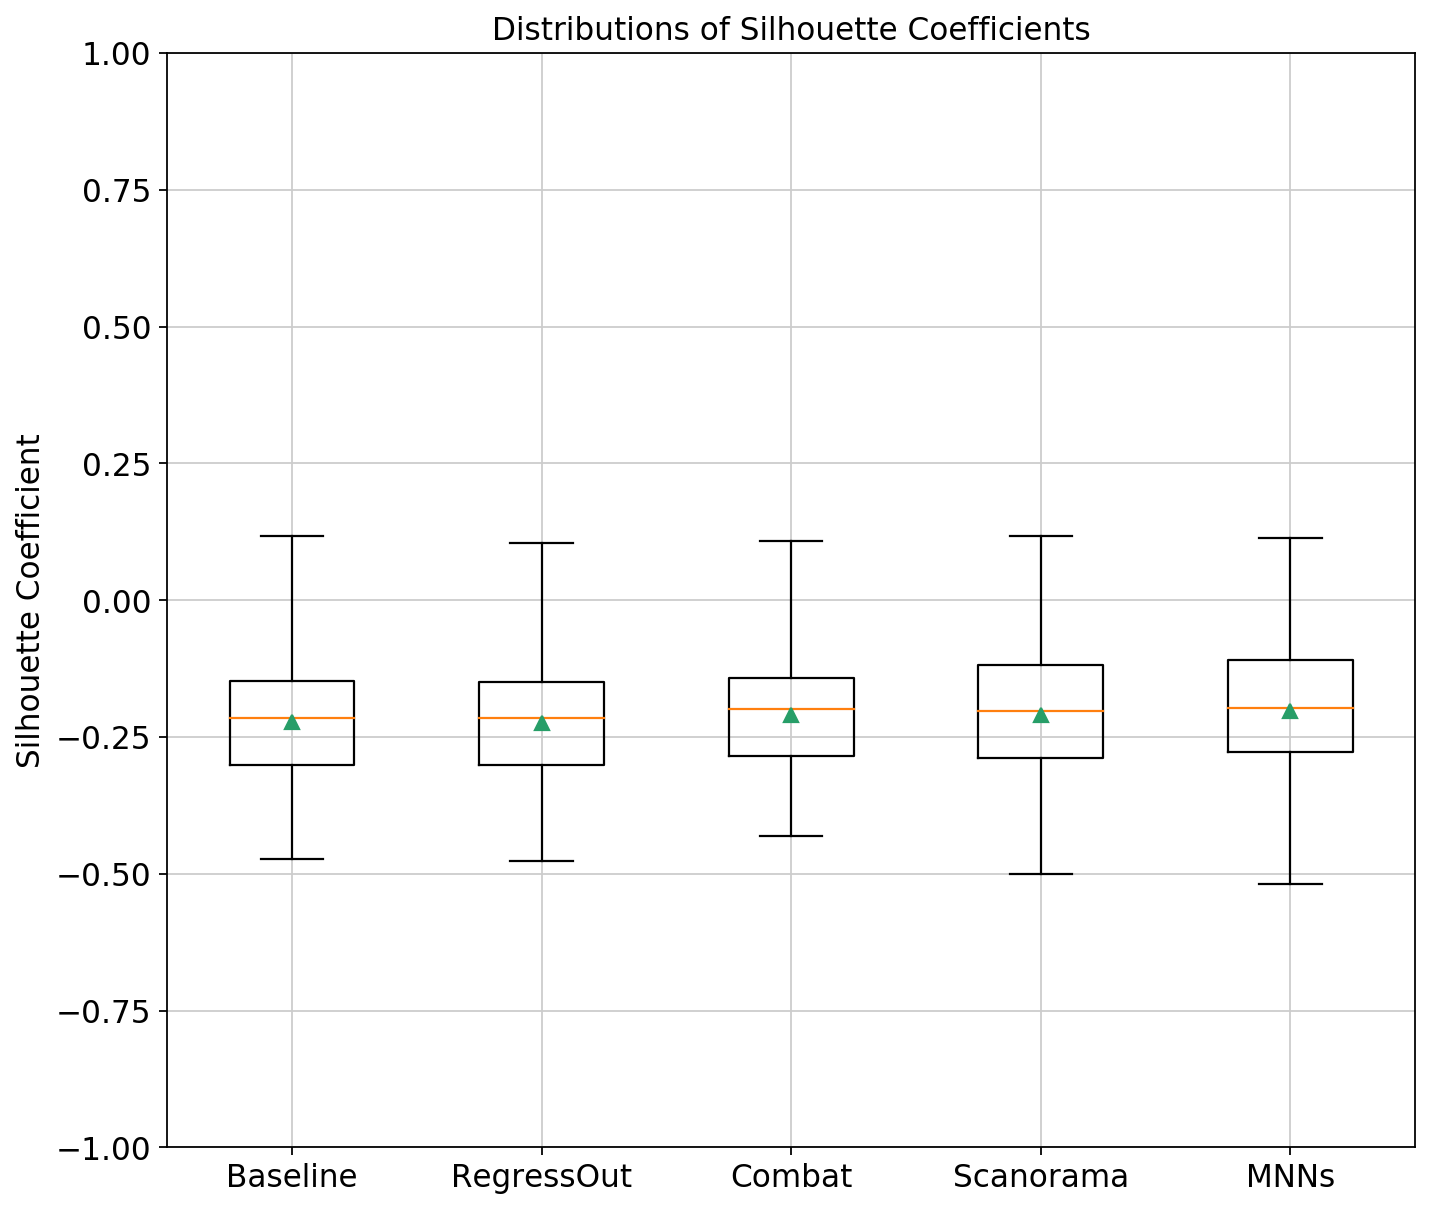

In [138]:
# visualization
plt.figure()
plt.boxplot([ sil_non, sil_regout, sil_scanpy, sil_scano, sil_MNN ], showmeans=True, whis='range')
plt.ylim([ -1, 1 ])
plt.title('Distributions of Silhouette Coefficients')
plt.xticks(range(1, 6), [ 'Baseline','RegressOut', 'Combat', 'Scanorama', "MNNs" ])
plt.ylabel('Silhouette Coefficient')
plt.savefig('silhouette_dge.svg')

In [139]:
X = adata.X

In [140]:
# Baseline Scanpy.
print("silh score of scanpy baseline")
sil_non = calculate_silh(X, './cluster_Baseline.txt')
# regout Scanpy
print("silh score of scanpy Regout:")
sil_regout = calculate_silh(X, 'cluster_reg.txt')
# regout Scanpy
print("silh score of scanpy Combat:")
sil_scanpy = calculate_silh(X, './cluster_Combat.txt')
# scanorama scanpy
print("silh score of Scanoram:")
sil_scano = calculate_silh(X,"./cluster_Scanorama.txt")
# MNNs
print("silh score of MNNs:")
sil_MNN = calculate_silh(X,"./cluster_MNNs.txt")

silh score of scanpy baseline
0.084994465
silh score of scanpy Regout:
0.08085913
silh score of scanpy Combat:
0.08424807
silh score of Scanoram:
0.076223165
silh score of MNNs:
0.1226115


In [141]:
print("\n\n-----Ttest------\n\n")
# t-test
print("ttest of regout to baseline:")
print(ttest_ind(sil_regout, sil_non))
print("ttest of regout to baseline:")
print(ttest_ind(sil_scanpy, sil_non))
print("ttest of scanoram to baseline:")
print(ttest_ind(sil_scano, sil_non))
print("ttest of MNNs to baseline:")
print(ttest_ind(sil_MNN, sil_non))



-----Ttest------


ttest of regout to baseline:
Ttest_indResult(statistic=-0.10804261584829647, pvalue=0.9139669353293224)
ttest of regout to baseline:
Ttest_indResult(statistic=-0.012217957317191462, pvalue=0.9902522906195024)
ttest of scanoram to baseline:
Ttest_indResult(statistic=-3.3925993731875215, pvalue=0.0006985899482437583)
ttest of MNNs to baseline:
Ttest_indResult(statistic=0.5526286884156525, pvalue=0.5805464581245108)


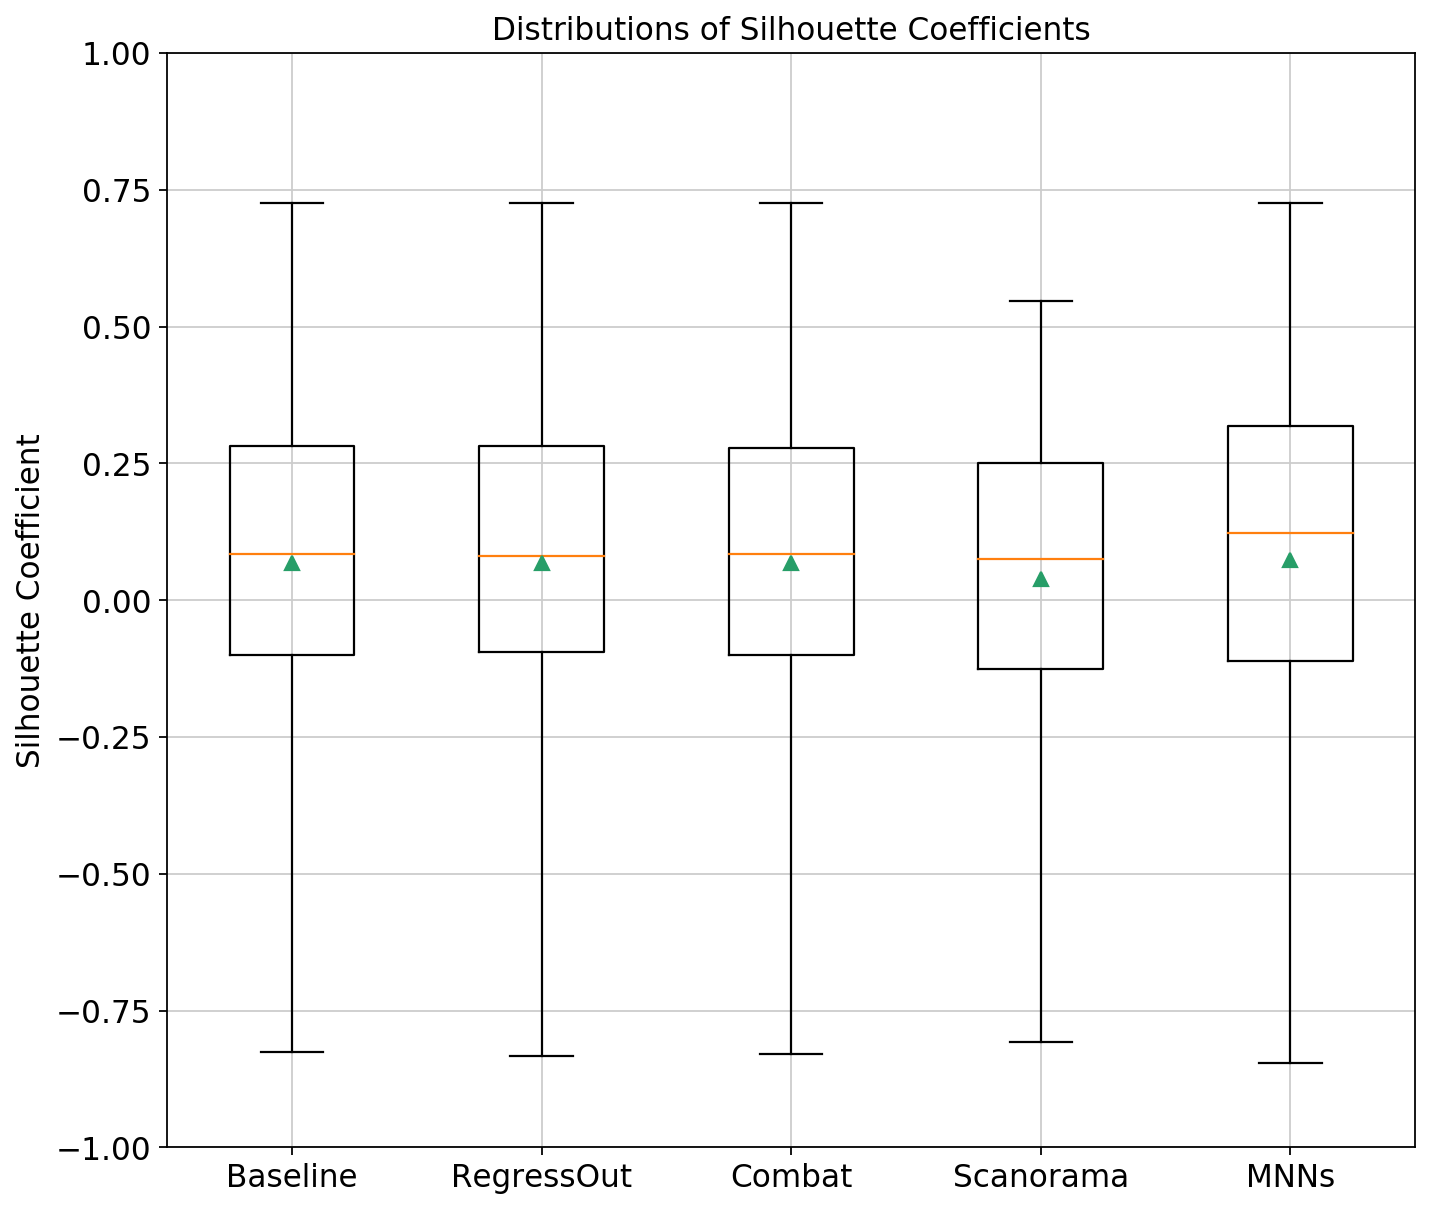

In [142]:
# visualization
plt.figure()
plt.boxplot([ sil_non, sil_regout, sil_scanpy, sil_scano, sil_MNN ], showmeans=True, whis='range')
plt.ylim([ -1, 1 ])
plt.title('Distributions of Silhouette Coefficients')
plt.xticks(range(1, 6), [ 'Baseline','RegressOut', 'Combat', 'Scanorama', "MNNs" ])
plt.ylabel('Silhouette Coefficient')
plt.savefig('silhouette_dge.svg')

In [143]:
# Baseline Scanpy.
print("silh score of scanpy baseline")
sil_non = calculate_silh(adata_base.X, './cluster_Baseline.txt')
# Regout Scanpy.
print("silh score of scanpy Regout")
sil_non = calculate_silh(adata_reg.X, './cluster_Baseline.txt')
# regout Scanpy
print("silh score of scanpy Combat:")
sil_scanpy = calculate_silh(adata_combat.X, './cluster_Combat.txt')
# scanorama scanpy
print("silh score of Scanoram:")
sil_scano = calculate_silh(corrected_merged_dge.X,"./cluster_Scanorama.txt")
# MNNs
print("silh score of MNNs:")
sil_MNN = calculate_silh(mnn_adata.X,"./cluster_MNNs.txt")

silh score of scanpy baseline
0.040653028
silh score of scanpy Regout
0.030259214
silh score of scanpy Combat:
0.03593930746047662
silh score of Scanoram:
-0.004459423
silh score of MNNs:
-0.013350563


In [144]:
print("\n\n-----Ttest------\n\n")
# t-test
print("ttest of regout to baseline:")
print(ttest_ind(sil_regout, sil_non))
print("ttest of regout to baseline:")
print(ttest_ind(sil_scanpy, sil_non))
print("ttest of scanoram to baseline:")
print(ttest_ind(sil_scano, sil_non))
print("ttest of MNNs to baseline:")
print(ttest_ind(sil_MNN, sil_non))



-----Ttest------


ttest of regout to baseline:
Ttest_indResult(statistic=9.395981669535766, pvalue=8.959666936569756e-21)
ttest of regout to baseline:
Ttest_indResult(statistic=1.8915183762729235, pvalue=0.05862241534084085)
ttest of scanoram to baseline:
Ttest_indResult(statistic=-4.583320675425643, pvalue=4.706478273688547e-06)
ttest of MNNs to baseline:
Ttest_indResult(statistic=-6.6505197661333835, pvalue=3.287017435861945e-11)


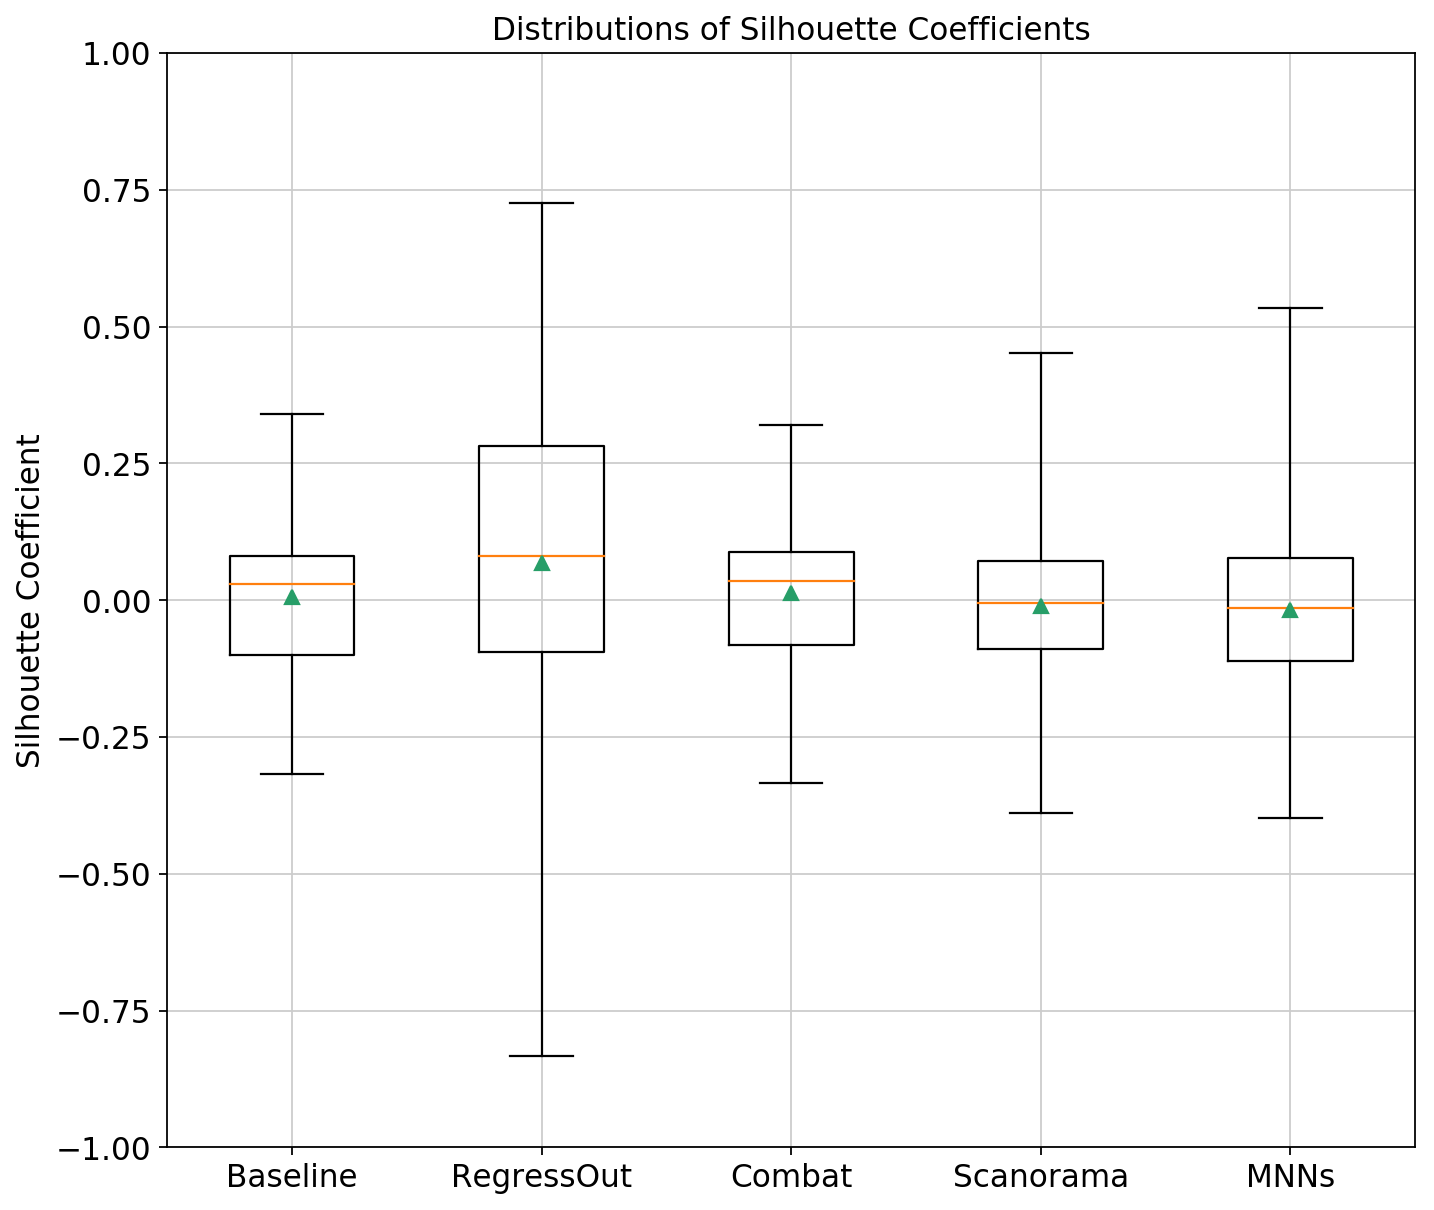

In [145]:
# visualization
plt.figure()
plt.boxplot([ sil_non, sil_regout, sil_scanpy, sil_scano, sil_MNN ], showmeans=True, whis='range')
plt.ylim([ -1, 1 ])
plt.title('Distributions of Silhouette Coefficients')
plt.xticks(range(1, 6), [ 'Baseline','RegressOut', 'Combat', 'Scanorama', "MNNs" ])
plt.ylabel('Silhouette Coefficient')
plt.savefig('silhouette_dge.svg')

In [146]:
dge.write("./dge.h5ad")
adata.write("./adata.h5ad")
adata_base.write("./adata_base.h5ad")
adata_combat.write("./adata_combat.h5ad")
adata_reg.write("./adata_reg.h5ad")
corrected_merged_dge.write("./adata_scanorama.h5ad")
mnn_adata.write("./adata_mnns.h5ad")

... storing 'Batch' as categorical
... storing 'cell_ontology_class' as categorical
... storing 'channel' as categorical
... storing 'CellType' as categorical
